In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom
from scipy.optimize import minimize
import scipy.stats as stats
from scipy.stats import beta, gaussian_kde
import torch
import torch.optim as optim
import torch.nn.functional as F


np.random.seed(22)
torch.manual_seed(22)	


In [22]:
data = pd.read_csv('data.csv')

In [23]:
print(data.head(10))

   study  control.deaths  control.total  treated.deaths  treated.total
0      1               3             39               3             38
1      2              14            116               7            114
2      3              11             93               5             69
3      4             127           1520             102           1533
4      5              27            365              28            355
5      6               6             52               4             59
6      7             152            939              98            945
7      8              48            471              60            632
8      9              37            282              25            278
9     10             188           1921             138           1916


In [24]:
data.describe()

,study,control.deaths,control.total,treated.deaths,treated.total
count,22.000000,22.000000,22.000000,22.000000,22.000000
mean,11.500000,44.772727,447.681818,37.545455,474.590909
std,6.493587,48.793961,486.389848,36.143533,491.747579
min,1.000000,3.000000,39.000000,3.000000,38.000000
25%,6.250000,12.500000,137.250000,8.250000,159.000000
50%,11.500000,37.500000,274.000000,27.500000,270.500000
75%,16.750000,46.500000,555.000000,54.000000,668.000000
max,22.000000,188.000000,1921.000000,138.000000,1916.000000


In [25]:
#sigma_2= 1/data['treated.deaths'] + 1/(data['treated.total']-data['treated.deaths']) + 1/data['control.deaths'] + 1/(data['control.total']-data['control.deaths'])

In [26]:
def log_joint(y0, n0, theta0, y1, n1, theta1):
    p0 = np.exp(theta0) / (1 + np.exp(theta0))
    p1 = np.exp(theta1) / (1 + np.exp(theta1))

    log_prior = theta0 + theta1 - 2 * (np.log(1 + np.exp(theta0)) + np.log(1 + np.exp(theta1)))
    log_lik0 = stats.binom.logpmf(y0, n0, p0)
    log_lik1 = stats.binom.logpmf(y1, n1, p1)
    
    log_joint = np.sum(log_lik0 + log_lik1) + log_prior
    return log_joint


def objective_joint(params, y0, n0, y1, n1, Z):
    mu0, mu1, log_s0, log_s1 = params
    s0, s1 = np.exp(log_s0), np.exp(log_s1)
    t0 = mu0 + s0 * Z[:, 0]
    t1 = mu1 + s1 * Z[:, 1]
    log_joints = np.array([log_joint(y0, n0, theta0, y1, n1, theta1) 
                       for theta0, theta1 in zip(t0, t1)])
    MC_logjoint = np.mean(log_joints)
    entropy = log_s0 + log_s1
    negative_elbo = - MC_logjoint- entropy
    return negative_elbo

def log_joint_advi(y0, n0, theta0, y1, n1, theta1):

    device = theta0.device
    dtype  = theta0.dtype
    y0 = torch.as_tensor(y0, dtype=dtype, device=device)
    n0 = torch.as_tensor(n0, dtype=dtype, device=device)
    y1 = torch.as_tensor(y1, dtype=dtype, device=device)
    n1 = torch.as_tensor(n1, dtype=dtype, device=device)

    p0 = torch.sigmoid(theta0)
    p1 = torch.sigmoid(theta1)

   
    log_prior = theta0 + theta1 - 2*(
        torch.log1p(torch.exp(theta0)) + torch.log1p(torch.exp(theta1))
        )

    # binomial log‑likelihoods
    log_lik0 = y0 * torch.log(p0) + (n0 - y0) * torch.log1p(-p0) # eed to verify if sum is needed
    log_lik1 = y1 * torch.log(p1) + (n1 - y1) * torch.log1p(-p1)

    return log_lik0 + log_lik1 + log_prior
    

def objective_joint_advi(params, y0, n0, y1, n1, Z):
    mu0, mu1, log_s0, log_s1 = params
    s0, s1 = torch.exp(log_s0), torch.exp(log_s1)
    t0 = mu0 + s0 * Z[:, 0]
    t1 = mu1 + s1 * Z[:, 1]
    log_joints = torch.stack([log_joint_advi(y0, n0, theta0, y1, n1, theta1) 
                             for theta0, theta1 in zip(t0, t1)])
    MC_logjoint = torch.mean(log_joints)
    entropy = log_s0 + log_s1
    negative_elbo = - MC_logjoint- entropy
    return negative_elbo


In [27]:
y0 = data['control.deaths'].values
n0 = data['control.total'].values
y1 = data['treated.deaths'].values
n1 = data['treated.total'].values

In [28]:

#Initial values for the parameters
p0_mle = np.sum(y0) / np.sum(n0)
theta0_init = np.log(p0_mle / (1 - p0_mle))

init_para = np.array([
    theta0_init,    # mu0
    0.0,            # mu1
    np.log(0.1),    # log_s0
    np.log(0.1)     # log_s1
])

ADVI 

In [29]:

#Z_advi = np.random.normal(size=(MC, 2))
#Z_advi = torch.tensor(Z_advi, dtype=torch.float32)

init_para_advi = torch.tensor(init_para, dtype=torch.float32, requires_grad=True)
optimizer = optim.SGD([init_para_advi], lr=0.01)

n_iter = 200 

for step in range(n_iter):
    Z_advi = torch.randn(1, 2) 
    optimizer.zero_grad()
    loss = objective_joint_advi(init_para_advi, y0, n0, y1, n1, Z_advi)
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        print(f"step {step:>4} | −ELBO {loss.item():.3f}")

with torch.no_grad():
    Z_eval  = torch.randn(5_000, 2)
    final_loss = objective_joint_advi(init_para_advi, y0, n0, y1, n1, Z_eval).mean()

final_elbo = -final_loss.item()
print(f"ADVI_ELBO: {final_elbo:.3f}")

mu0_opt_advi, mu1_opt_advi, log_s0_opt_advi, log_s1_opt_advi = init_para_advi.detach().cpu().numpy()
s0_opt_advi = np.exp(log_s0_opt_advi)
s1_opt_advi = np.exp(log_s1_opt_advi)


print(f"Optimized mu0 (ADVI): {mu0_opt_advi:.3f}")
print(f"Optimized mu1 (ADVI): {mu1_opt_advi:.3f}")
print(f"Optimized log_s0 (ADVI): {log_s0_opt_advi:.3f}")
print(f"Optimized log_s1 (ADVI): {log_s1_opt_advi:.3f}")




step    0 | −ELBO 473.063
step   50 | −ELBO 285.936
step  100 | −ELBO 288.017
step  150 | −ELBO 288.073
ADVI_ELBO: -286.662
Optimized mu0 (ADVI): -2.124
Optimized mu1 (ADVI): -2.353
Optimized log_s0 (ADVI): -1.943
Optimized log_s1 (ADVI): -1.785


DADVI

In [34]:
# Monte Carlo draws (2D)
MC = 200
np.random.seed(22)
Z_dadvi = np.random.randn(MC, 2)

# === Optimize joint variational parameters ===
res = minimize(objective_joint, init_para, args=(y0, n0, y1, n1, Z_dadvi))


mu0_opt_dadvi, mu1_opt_dadvi, log_s0_opt_dadvi, log_s1_opt_dadvi = res.x
s0_opt_dadvi, s1_opt_dadvi = np.exp(log_s0_opt_dadvi), np.exp(log_s1_opt_dadvi)
print(f'"DADVI_ELBO:", {(- res.fun):.3f}')



"DADVI_ELBO:", -274.431


DADVI_p0 = 0.100, DADVI_std_p0 = 0.003
ADVI_p0 = 0.108, ADVI_std_p0 = 0.014
MLE of P0: 0.100
DADVI_p1 = 0.079, DADVI_std_p1= 0.002
ADVI_p1 = 0.088, ADVI_std_p1= 0.013
MLE of P1: 0.079


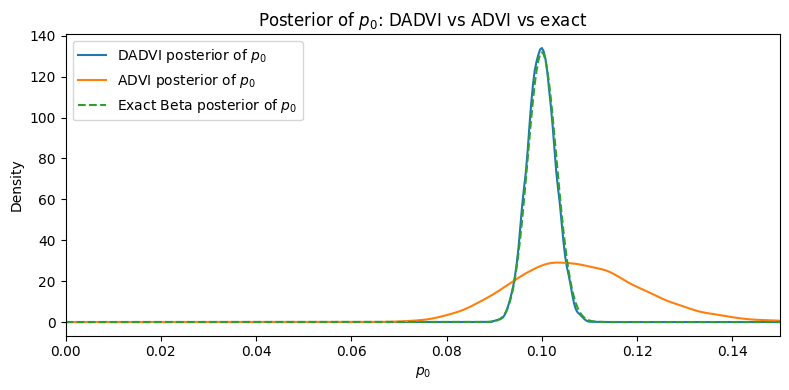

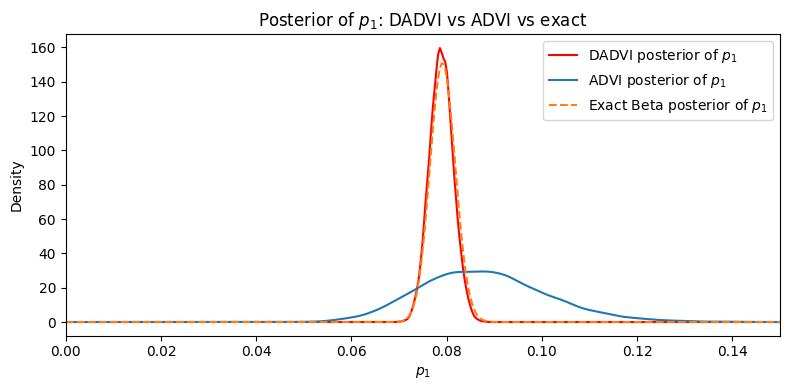

In [33]:
# Draw posterior P0, P1 samples using the optimized parameters
M = 10000
theta_samps_dadvi = np.vstack([
    mu0_opt_dadvi + s0_opt_dadvi * np.random.randn(M),
    mu1_opt_dadvi + s1_opt_dadvi * np.random.randn(M)
]).T # get an array of shape (M, 2) whose rows are the samples of theta0 and theta1 

theta_samps_advi = np.vstack([
    mu0_opt_advi + s0_opt_advi * np.random.randn(M),
    mu1_opt_advi + s1_opt_advi * np.random.randn(M)
]).T

p0_samps_dadvi = np.exp(theta_samps_dadvi[:, 0]) / (1 + np.exp(theta_samps_dadvi[:, 0]))
p0_samps_advi = np.exp(theta_samps_advi[:, 0]) / (1 + np.exp(theta_samps_advi[:, 0]))
p1_samps_dadvi = np.exp(theta_samps_dadvi[:, 1]) / (1 + np.exp(theta_samps_dadvi[:, 1]))
p1_samps_advi = np.exp(theta_samps_advi[:, 1]) / (1 + np.exp(theta_samps_advi[:, 1]))


# Results
print(f"DADVI_p0 = {p0_samps_dadvi.mean():.3f}, DADVI_std_p0 = {p0_samps_dadvi.std():.3f}")
print(f"ADVI_p0 = {p0_samps_advi.mean():.3f}, ADVI_std_p0 = {p0_samps_advi.std():.3f}")
print(f'MLE of P0: {(np.sum(y0) / np.sum(n0)):.3f}')  #Maximum Likelihood Estimate of P0

print(f"DADVI_p1 = {p1_samps_dadvi.mean():.3f}, DADVI_std_p1= {p1_samps_dadvi.std():.3f}")
print(f"ADVI_p1 = {p1_samps_advi.mean():.3f}, ADVI_std_p1= {p1_samps_advi.std():.3f}")
print(f'MLE of P1: {(np.sum(y1) / np.sum(n1)):.3f}')


# Visualize the posterior samples: VI posterior vs exact posterior
x = np.linspace(0, 0.15, 400)

kde_dadvi_p0 = gaussian_kde(p0_samps_dadvi)
kde_dadvi_p1 = gaussian_kde(p1_samps_dadvi)
dadvi_dens_p0 = kde_dadvi_p0(x)
dadvi_dens_p1 = kde_dadvi_p1(x)

kde_advi_p0  = gaussian_kde(p0_samps_advi)
kde_advi_p1  = gaussian_kde(p1_samps_advi)
advi_dens_p0 = kde_advi_p0(x)
advi_dens_p1 = kde_advi_p1(x)

alpha_p0, beta_param_p0 = y0.sum() + 1, n0.sum() - y0.sum() + 1
alpha_p1, beta_param_p1 = y1.sum() + 1, n1.sum() - y1.sum() + 1

beta_dens_p0 = beta.pdf(x, alpha_p0, beta_param_p0)
beta_dens_p1 = beta.pdf(x, alpha_p1, beta_param_p1)


plt.figure(figsize=(8, 4))
plt.plot(x, dadvi_dens_p0,  label='DADVI posterior of $p_0$')
plt.plot(x, advi_dens_p0,   label='ADVI posterior of $p_0$')
plt.plot(x, beta_dens_p0,  '--', label='Exact Beta posterior of $p_0$')

plt.xlim(0, 0.15)
plt.xlabel(r'$p_0$')
plt.ylabel('Density')
plt.title('Posterior of $p_0$: DADVI vs ADVI vs exact')
plt.legend()
plt.tight_layout()


plt.figure(figsize=(8, 4))
plt.plot(x, dadvi_dens_p1,  color = 'r', label='DADVI posterior of $p_1$')
plt.plot(x, advi_dens_p1,   label='ADVI posterior of $p_1$')
plt.plot(x, beta_dens_p1,  '--', label='Exact Beta posterior of $p_1$')

plt.xlim(0, 0.15)
plt.xlabel(r'$p_1$')
plt.ylabel('Density')
plt.title('Posterior of $p_1$: DADVI vs ADVI vs exact')
plt.legend()
plt.tight_layout()



